# How to properly prevent overfitting

**Objectives:**
- Give a `Validation Set` to the model
- Use the `Early Stopping` criterion to prevent the Neural network from overfitting
- `Regularize` your network

## Data 

First, let's generate some data thanks to the [`make_blob`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function that we've already used yesterday.

❓ **Question** ❓ Generate 2000 samples, with 10 features each. 

There should be 8 classes of blobs (`centers` argument), with `cluster_std` equal to 7. 

Plot some dimensions to check your data.

In [37]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_blobs(n_samples=2000, centers=8, n_features=10, cluster_std=7)

In [38]:
X.shape

(2000, 10)

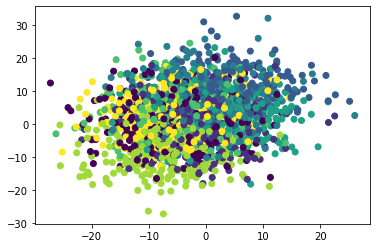

In [39]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y);

❓ **Question** ❓ Use the `to_categorical` function from `tensorflow.keras` to convert `y` to `y_cat` which is the categorical representation of `y` with "*one-hot encoded*" columns.

In [40]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y, num_classes=8)
y_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)


## Part I : Proper cross-validation

In a previous challenge, we split the dataset into a train set and a test set at the beginning of the notebook. 

And then, we started to build different models which were trained on the train set and evaluated on the test set.

So, at the end of the day, we used the test set everytime we evaluated our models and different hyperparameters. 

Therefore, we _used_ the test set to select our best model, which is a sort of ⚠️ `data-leakage` ⚠️.

A first good practice is to avoid using `random_state` or any deterministic separation between your train and test set. In that case, your test set will change everytime you re-run your notebook. But this is far from being sufficient.

To compare models properly, you have to run a cross-validation, a 10-fold split for instance. Let's see how to do it properly.

❓ **Question** ❓ First, write a function that generates a neural network with 3 layers:
- a layer with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a layer with 10 neurons and the `relu` activation function.
- a last layer which is suited to the problem at hand (multiclass classification)

The function should include a compilation method with :
- the `categorical_crossentropy` loss, 
- the `adam` optimizer 
- and the `accuracy` metrics.

In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Sequential

def initialize_model():
    model = Sequential()
    model.add(layers.Dense(25, input_dim=10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Here, we will do a proper cross validation.

❓ **Question** ❓ Write a loop using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn  (choose 10 splits) to fit your model on the train data, and evaluate it on the test data. Store the results of the evaluation into a `results` variable.

Do not forget to standardize your train data before fitting the neural network.

Also, 150 epochs should be sufficient for a first approximation

In [55]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=10)
kf.get_n_splits(X)

scaler = StandardScaler()

results = []

for train_index, test_index in kf.split(X):
    # Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    # Initialize the model
    model = initialize_model()
    
    # Fit the model on the train data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    
    # Evaluate the model on the test data and append the result in the `results` variable
    results.append(model.evaluate(X_test, y_test, verbose=0)[1])

❓ **Question** ❓ Print the mean accuracy, and its standard deviation

In [56]:
np.mean(results)

0.7804999947547913

In [57]:
np.std(results)

0.0182277326212438

❗ **Remark** ❗ You probably encountered one of the main drawbacks of using a proper cross-validation for a Neural Network: **it takes a lot of time** ! Therefore, for the rest of the Deep-Learning module, we will do **only one split**. But remember that this is not entirely correct and, for real-life applications and problems, you are encouraged to use a proper cross-validation technique.

❗ **Remark** ❗ In general, what practitioners do, is that they split only once, as you did. And once they get to the end of their optimization, they launch a real cross-validation at 6pm, go home and get the final results on the next day.

❓ **Question** ❓ For the rest of the exercise (and of the Deep Learning module), split the dataset into a train set and a test set with a 70/30% training to test data ratio.



In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=0)

## Part II : Stop the learning process before overfitting

Let's first show that if we train the model for too long, too many epochs, it will overfit the training data and will not be good at predicting on the test data.

❓ **Question** ❓ To do it, train the same neural network (⚠️ do not forget to re-initialize it ⚠️) with `validation_data=(X_test, y_test)` and 500 epochs. Store the history in a `history` variable.

In [60]:
model = initialize_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    batch_size=32,
                    verbose=0)

❓ **Question** ❓ Evaluate the model on the test set and print the accuracy

In [62]:
model.evaluate(X_test, y_test, verbose=0)[1]

0.7233333587646484

❓ **Question** ❓ Plot the history of the model with the following function : 

In [63]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

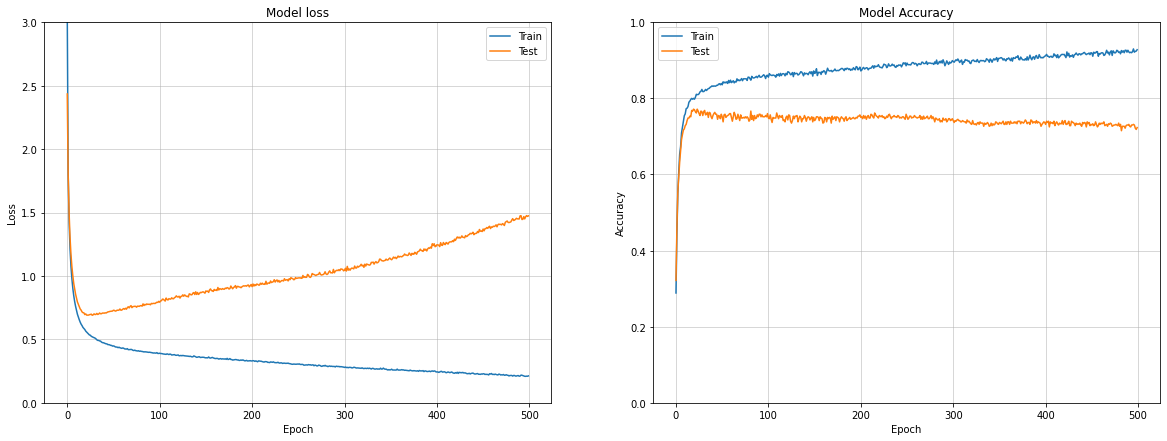

In [64]:
plot_loss_accuracy(history)

We clearly see that the number of epochs we chose has a great influence on the final results: 

* `Unsufficient number of  epochs` $\rightarrow$ `Underfitting`:
    * The algorithm is not optimal as its loss function has not converged yet, 
    * i.e. it hasn't learnt enough from the training data. 
* `Too many epochs` $\rightarrow$ `Overfitting`: 
    * Our neural network has learnt too much from the training data, even its noisy information... 
    * and the algorithm does not generalize well on test data.

What we want is basically to ***stop the algorithm when the test loss is minimal*** (or when the test accuracy is maximal).

Let's introduce the **`Early Stopping`** criterion.

The ES criterion is a way to automatically stop the training of the algorithm before the end, before the final number of epochs originally set.

❓ How does it work ❓

Basically, it uses part of the dataset to check whether the test loss has stopped improving. You cannot use the test data itself to check that, otherwise, it is some kind of data leakage. Instead, we will use a subset of the initial training data, called the **`validation set`**

It basically looks like the following 👇

<img src="validation_set.png" alt="Validation set" style="height:350px;"/>

To split this data, we use the **`validation_split`** keyword which sets the percentage of data from the initial training set used in the validation set.

You need to specify it when fitting the model in the `.fit()`. -

On top of that, we use the **`callbacks`** keyword to call the Early Stopping criterion at the end of each epoch. You can check additional information in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate)


❓ **Question** ❓ Launch the following code, plot the history and evaluate it on the test set

In [69]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping()

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=1, 
                    callbacks=[es])

TypeError: fit() got an unexpected keyword argument 'patience'

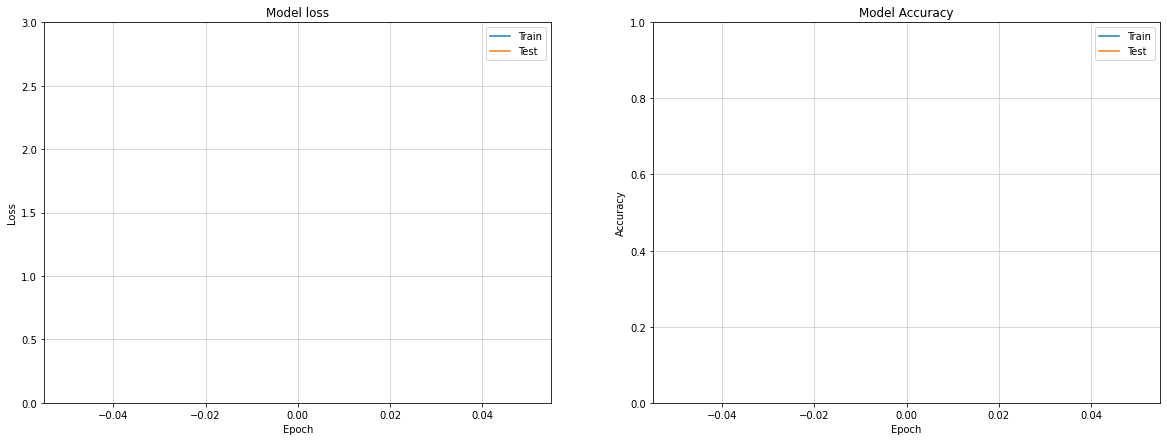

In [70]:
plot_loss_accuracy(history)

❗ **Remark** ❗ The problem, with this type of approach, is that as soon as the loss of the validation set increases, the model stops. However, as a neural network's convergence is stochastic, it happens that the loss slightly increases before decreasing again. For this reason, the `Early Stopping` criterion has a **`patience`** keyword that `defines how many consecutive epochs without any loss decrease` are allowed before we stop the training procedure.

❓ **Question** ❓ Use the Early Stopping criterion with a patience of 30 epochs, plot the results and print the accuracy on the test set

In [71]:
es = EarlyStopping(patience=30)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
62/62 [==============================] - 1s 8ms/step - loss: 4.2045 - accuracy: 0.1083 - val_loss: 2.8454 - val_accuracy: 0.1116
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 2.3655 - accuracy: 0.1869 - val_loss: 2.1096 - val_accuracy: 0.1924
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 1.9073 - accuracy: 0.2870 - val_loss: 1.8524 - val_accuracy: 0.2874
Epoch 4/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6848 - accuracy: 0.3687 - val_loss: 1.6704 - val_accuracy: 0.3800
Epoch 5/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5054 - accuracy: 0.4535 - val_loss: 1.4779 - val_accuracy: 0.5226
Epoch 6/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3169 - accuracy: 0.5301 - val_loss: 1.2885 - val_accuracy: 0.5914
Epoch 7/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1507 - accuracy: 0.5884 - val_loss: 1.1588 - val_accuracy: 0.6081
Epoch 8/500
6

Epoch 59/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3709 - accuracy: 0.8744 - val_loss: 0.7829 - val_accuracy: 0.7648
Epoch 60/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8703 - val_loss: 0.7844 - val_accuracy: 0.7625
Epoch 61/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3640 - accuracy: 0.8713 - val_loss: 0.7899 - val_accuracy: 0.7625
Epoch 62/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8733 - val_loss: 0.8007 - val_accuracy: 0.7577
Epoch 63/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8784 - val_loss: 0.7897 - val_accuracy: 0.7553
Epoch 64/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8754 - val_loss: 0.7895 - val_accuracy: 0.7625


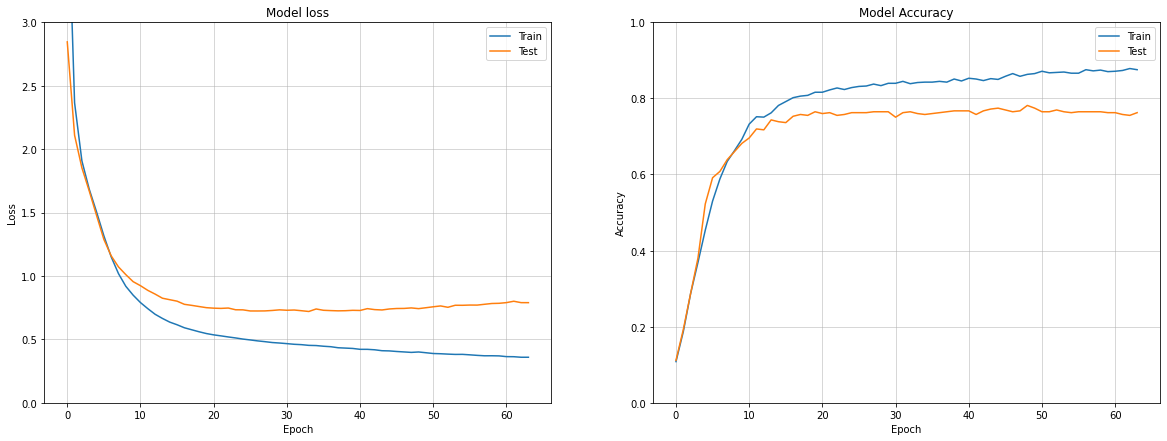

In [72]:
plot_loss_accuracy(history)

❗ **Remark** ❗ The model continues to converge even though its loss functions have some consecutive loss increases and decreases. 

The `patience` number  to select is highly related to the task at hand and there is not any general rule of thumb. 

❗ **Remark** ❗ If you selected a high patience value, you might face the problem that the loss on the validation set has increased again a lot compared to its lowest value. To that end, the Early Stopping criterion enables you to stop the convergence _and_ **`restore the best weights of the neural network when it had the best score on the validation set`**, thanks to **`restore_best_weights = True`** (that is set to `False` by default).

❓ **Question** ❓ Run the model with a Early Stopping criterion that will restore the best weights of the Neural Net, plot the loss and accuracy and print the accuracy on the test set

In [73]:
es = EarlyStopping(patience=30, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=500,
                    batch_size=16, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
62/62 [==============================] - 0s 3ms/step - loss: 3.9406 - accuracy: 0.1665 - val_loss: 2.6560 - val_accuracy: 0.2470
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 2.0768 - accuracy: 0.3401 - val_loss: 1.7313 - val_accuracy: 0.4062
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 1.4998 - accuracy: 0.4617 - val_loss: 1.3894 - val_accuracy: 0.5249
Epoch 4/500
62/62 [==============================] - 0s 3ms/step - loss: 1.2427 - accuracy: 0.5669 - val_loss: 1.2099 - val_accuracy: 0.5796
Epoch 5/500
62/62 [==============================] - 0s 3ms/step - loss: 1.0943 - accuracy: 0.6302 - val_loss: 1.0887 - val_accuracy: 0.6081
Epoch 6/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9814 - accuracy: 0.6813 - val_loss: 1.0060 - val_accuracy: 0.6532
Epoch 7/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9076 - accuracy: 0.6936 - val_loss: 0.9515 - val_accuracy: 0.6817
Epoch 8/500
6

Epoch 59/500
62/62 [==============================] - 0s 4ms/step - loss: 0.3884 - accuracy: 0.8611 - val_loss: 0.8392 - val_accuracy: 0.7458
Epoch 60/500
62/62 [==============================] - 0s 4ms/step - loss: 0.3879 - accuracy: 0.8641 - val_loss: 0.8315 - val_accuracy: 0.7458
Epoch 61/500
62/62 [==============================] - 0s 3ms/step - loss: 0.3827 - accuracy: 0.8570 - val_loss: 0.8413 - val_accuracy: 0.7435
Epoch 62/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3805 - accuracy: 0.8672 - val_loss: 0.8709 - val_accuracy: 0.7340
Epoch 63/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3769 - accuracy: 0.8682 - val_loss: 0.8425 - val_accuracy: 0.7506


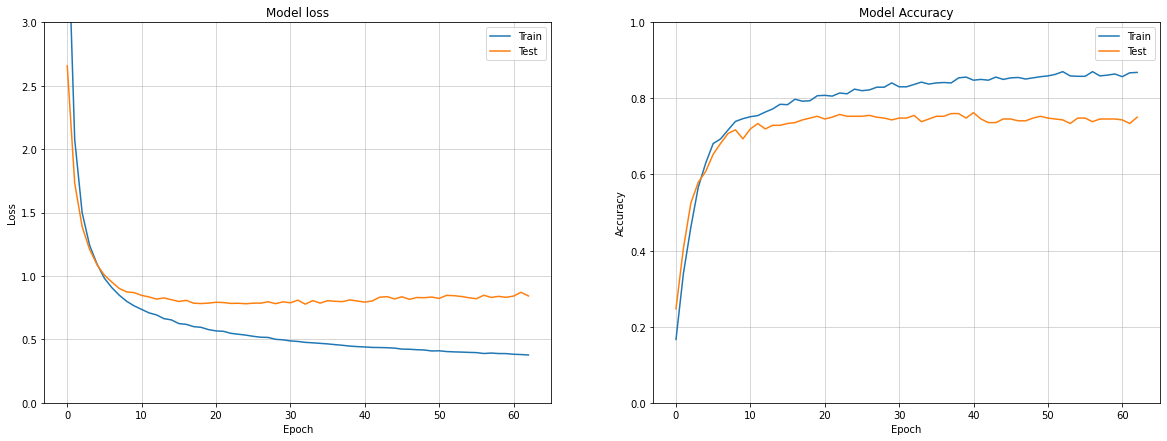

In [74]:
plot_loss_accuracy(history)

In [75]:
model.evaluate(X_test, y_test, verbose=0)[1]

0.7450000047683716

❗ **Remark 1** ❗ You can look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to play with other parameters

❗ **Remark 2** ❗ No longer need to have a look at the epochs as long as the model hits the stopping criterion. So, in the future, you should set a large number of epochs and the early stopping criterion will take care of stopping the training procedure before the model overfits. 

## Part III : Batch-size & Epochs

❓ **Question** ❓ Let's run the previous model with different batch sizes (with the Early Stopping criterion included) and plot the results.

CPU times: user 1min 11s, sys: 34.5 s, total: 1min 46s
Wall time: 42 s


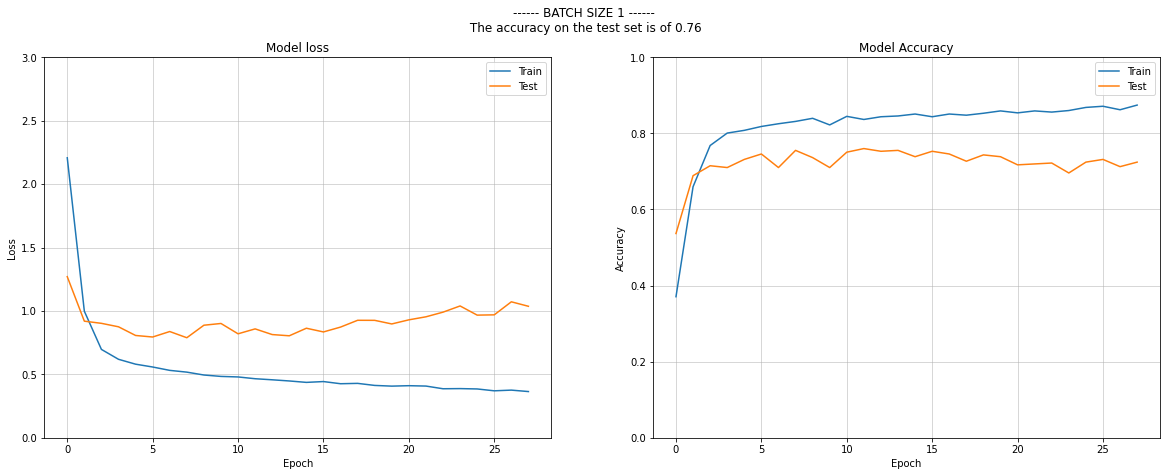

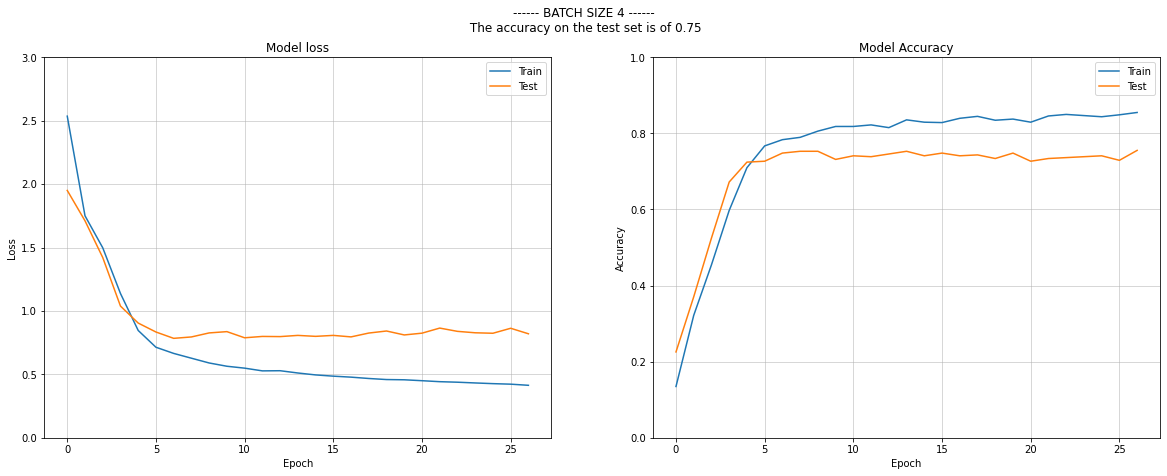

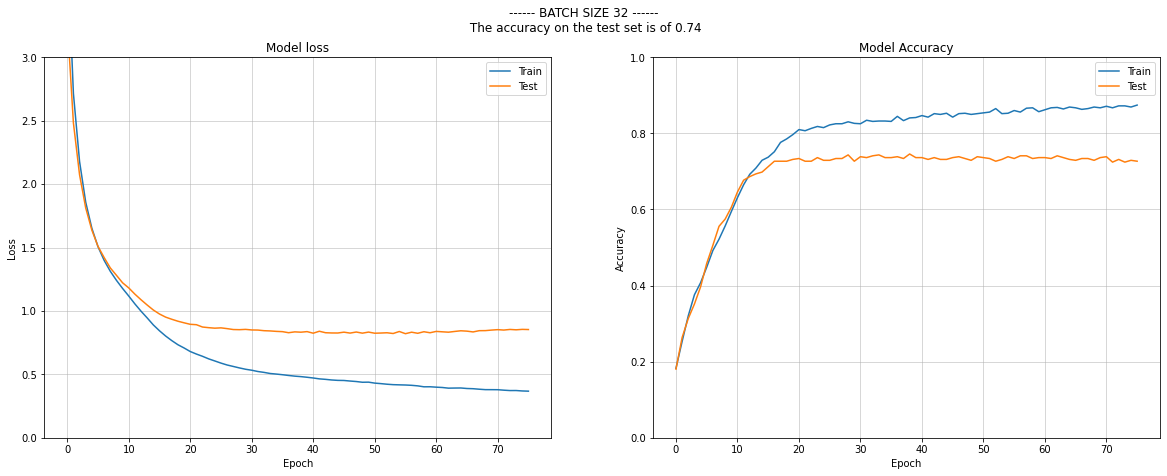

In [76]:
%%time
# RUN THIS CELL (it can take some time...)

es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [1, 4, 32]:
    
    model = initialize_model()

    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=500,
                        batch_size=batch_size, 
                        verbose=0, 
                        callbacks=[es])

    results = model.evaluate(X_test, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

❓ **Question** ❓ Look at the oscillations of the accuracy and the loss with respect to the batch size number. Is this coherent with what we saw when playing with the Tensorflow Playground? 

In [ ]:
Yes

❓ **Questions** ❓ 
* How many optimizations of the weights are done within one epoch (with respect to the number of observations and the batch size)? 
* Therefore, is one epoch longer with a large or a small batch size?

# Part IV: Regularization

In this part of the notebook, we will see how to use `**regularizers**` in a neural network. 

Regularizers are used to `prevent overfitting` that can happen because very complex networks have many  parameters which tends to overfit the training data.

First, let's initialize a model that has too many parameters for the task (many layers and/or many neurons) such that it overfits the training data  
**To better see the effect, we will not use any early stopping criterion**

The accuracy on the test set is of 0.70


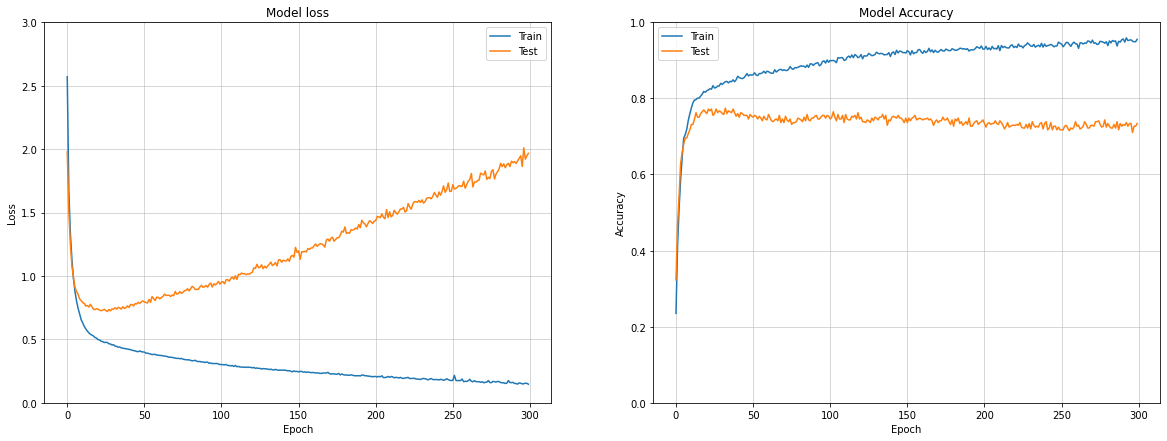

In [77]:
# RUN THIS CELL

model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,  validation_split=0.3,
                    epochs=300, batch_size=16, verbose=0)

results = model.evaluate(X_test, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')
plot_loss_accuracy(history)

☝️ In our *overparametrized network*, some neurons became too specific to given training data, preventing the network from generalizing to new data. 

😕 This led to some overfitting. 

⚔️ We discovered the Early Stopping criterion as a weapon to fight overfitting.

Two additional tools can be used to fight overfitting, they are specific layers:

* ✂️ <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout">**`Dropout Layers`**</a> : 
    * Their role is to _cancel_ the output of some neurons  during the training part. 
    * By doing this at random, it prevents the network from getting too specific to the input data : no any neuron can be too specific to a given input as its output is sometimes cancelled by the Dropout Layer. Overall, it forces the information that is contained in one input sample to go through multiple neurons instead of only one specific neuron.

* 👮🏻‍♀️ <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers">**`Regularizers`**</a>: as Sequential Dense Neural Networks are simple activated linear regressions, the weights can be constrained using L1, L2 or L1-L2 penalties! Wow!


❓ **Question** ❓ Try to add dropout layers and regularization to all your layers of the above neural network and look at the effect on the loss on the test set.

🏁 **Congratulations!** 

Don't forget to commit and push your challenge